PRE-PROCESSING AND SAVING DATA

In [1]:
import os
import pandas as pd
import cv2
import numpy as np

# Load CSV file
csv_file = r'C:\Users\sruth\OneDrive\Documents\sdp\DR_grading.csv'
df = pd.read_csv(csv_file)

# Define the image folder path
image_folder = r'C:\Users\sruth\OneDrive\Documents\sdp\DR_grading\DR_grading'

# Check the dataset structure
print(df.head())

# Preprocess the images (example function)
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, (128, 128))  # Resize to the required input size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Load images and labels
X = []
y = []

for _, row in df.iterrows():
    image_path = os.path.join(image_folder, row['id_code'])
    image = load_image(image_path)
    X.append(image)
    y.append(row['diagnosis'])

X = np.array(X)
y = np.array(y)

# Check the shape of loaded data
print(X.shape, y.shape)

# Save the preprocessed data for later use
np.savez_compressed(r'C:\Users\sruth\OneDrive\Documents\sdp\DR Files\DR_grading_preprocessed.npz', X=X, y=y)

print("Data saved successfully!")

                 id_code  diagnosis
0  20170413102628830.jpg          0
1  20170413111955404.jpg          0
2  20170413112015395.jpg          0
3  20170413112017305.jpg          0
4  20170413112528859.jpg          0
(12522, 128, 128, 3) (12522,)
Data saved successfully!


CHECKING SHAPE OF PRE PROCESSING DATA

In [2]:
import numpy as np
# Load preprocessed data
data = np.load(r'C:\Users\sruth\OneDrive\Documents\sdp\DR Files\DR_grading_preprocessed.npz')

# Retrieve images and labels
X = data['X']
y = data['y']

# Check the shape of the loaded data
print(X.shape, y.shape)

(12522, 128, 128, 3) (12522,)


DENSENET-121 RUNNING

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and validation data
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# Define the model creation function
def create_densenet_model(input_shape=(128, 128, 3), num_classes=5):  # Adjust num_classes based on your dataset
    # Load the pre-trained DenseNet121 model without the top layers
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model layers

    # Create the full model using a Sequential API
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Adjust activation based on the type of classification (softmax for multiclass)
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model (adjust input_shape and num_classes as necessary)
model = create_densenet_model(input_shape=(128, 128, 3), num_classes=5)  # Assuming 5 classes

# Summary of the model architecture
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Optionally, save the trained model
model.save(r'C:\Users\sruth\OneDrive\Documents\sdp\DR_grading_densenet_model.h5')

# Print training history (optional)
print("Training history:", history.history)


Training data shape: (10017, 128, 128, 3), Validation data shape: (2505, 128, 128, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,092,229 (30.87 MB)

 Trainable params: 1,054,725 (4.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 229s 684ms/step - accuracy: 0.5710 - loss: 1.3842 - val_accuracy: 0.6591 - val_loss: 0.8581
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 194s 618ms/step - accuracy: 0.6489 - loss: 0.8773 - val_accuracy: 0.6355 - val_loss: 0.8933
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 196s 624ms/step - accuracy: 0.6611 - loss: 0.8570 - val_accuracy: 0.6623 - val_loss: 0.8381
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 197s 626ms/step - accuracy: 0.6550 - loss: 0.8647 - val_accuracy: 0.6862 - val_loss: 0.7919
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 193s 613ms/step - accuracy: 0.6751 - loss: 0.8283 - val_accuracy: 0.6727 - val_loss: 0.8494
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 196s 625ms/step - accuracy: 0.6703 - loss: 0.8227 - val_accuracy: 0.6830 - val_loss: 0.8032
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 194s 619ms/step - accuracy: 0.6843 - loss: 0.8081 - val_accuracy: 0.6862 - val_loss: 0.7854
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 196s 624ms/step - accuracy: 0.6963 -

Training history: {'accuracy': [0.6105620265007019, 0.6568832993507385, 0.666467010974884, 0.6697614192962646, 0.678945779800415, 0.6773484945297241, 0.6876310110092163, 0.688329815864563, 0.6948187947273254, 0.6973145604133606], 'loss': [1.0566563606262207, 0.8722819685935974, 0.8466622233390808, 0.8331798911094666, 0.8202579021453857, 0.8157661557197571, 0.799968421459198, 0.7970190644264221, 0.7840023040771484, 0.7742519974708557], 'val_accuracy': [0.6590818166732788, 0.6355289220809937, 0.6622754335403442, 0.686227560043335, 0.6726546883583069, 0.6830339431762695, 0.686227560043335, 0.6906187534332275, 0.7033932209014893, 0.6978043913841248], 'val_loss': [0.8580901622772217, 0.8933145403862, 0.8380822539329529, 0.7918607592582703, 0.8493930101394653, 0.8031550049781799, 0.7853986024856567, 0.8293069005012512, 0.7760394811630249, 0.7692888975143433]}


HYPERPARAMETER TUNING - RAM CRASHED INITIALLY

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# Define a function for building the model
def build_model(units, dropout, learning_rate):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(5, activation='softmax')  # Adjust num_classes as needed
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define hyperparameter ranges
units_range = [512, 640, 768, 896, 1024]
dropout_range = [0.3, 0.4, 0.5, 0.6, 0.7]
learning_rate_range = [1e-2, 1e-3, 1e-4]

# Manual tuning loop
best_val_accuracy = 0
best_params = None
best_model = None

for units in units_range:
    for dropout in dropout_range:
        for learning_rate in learning_rate_range:
            print(f"Training with units={units}, dropout={dropout}, learning_rate={learning_rate}")

            # Build the model with current hyperparameters
            model = build_model(units, dropout, learning_rate)

            # Early stopping to prevent overfitting
            stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=20,
                validation_data=(X_val, y_val),
                batch_size=32,
                callbacks=[stop_early],
                verbose=0
            )

            # Evaluate the model
            val_accuracy = max(history.history['val_accuracy'])
            print(f"Validation accuracy: {val_accuracy}")

            # Track the best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_params = {'units': units, 'dropout': dropout, 'learning_rate': learning_rate}
                best_model = model

print(f"Best hyperparameters: {best_params}")
print(f"Best validation accuracy: {best_val_accuracy}")

# Save the best model
best_model.save(r'C:\Users\sruth\OneDrive\Documents\sdp\DR Files\DR_grading_best_model_manual.h5')


Training data shape: (10017, 128, 128, 3), Validation data shape: (2505, 128, 128, 3)
Training with units=512, dropout=0.3, learning_rate=0.01
Validation accuracy: 0.6822355389595032
Training with units=512, dropout=0.3, learning_rate=0.001
Validation accuracy: 0.7165668606758118
Training with units=512, dropout=0.3, learning_rate=0.0001
Validation accuracy: 0.7249500751495361
Training with units=512, dropout=0.4, learning_rate=0.01
Validation accuracy: 0.677445113658905
Training with units=512, dropout=0.4, learning_rate=0.001
Validation accuracy: 0.723752498626709
Training with units=512, dropout=0.4, learning_rate=0.0001
Validation accuracy: 0.7289420962333679
Training with units=512, dropout=0.5, learning_rate=0.01
Validation accuracy: 0.6558881998062134
Training with units=512, dropout=0.5, learning_rate=0.001
Validation accuracy: 0.7181636691093445
Training with units=512, dropout=0.5, learning_rate=0.0001
Validation accuracy: 0.714970052242279
Training with units=512, dropout=0.

: 

SINCE RAM CRASHED WE TRIED HYPERPARAMETER TUNING AGAIN

In [ ]:
import numpy as np
# Load preprocessed data
data = np.load(r'C:\Users\sruth\OneDrive\Documents\sdp\DR Files\DR_grading_preprocessed.npz')

# Retrieve images and labels
X = data['X']
y = data['y']

# Check the shape of the loaded data
print(X.shape, y.shape)

(12522, 128, 128, 3) (12522,)


HYPERPARAMETER TUNING

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# Define a function for building the model
def build_model(units, dropout, learning_rate):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(5, activation='softmax')  # Adjust num_classes as needed
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define hyperparameter ranges
units_range = [640, 768]
dropout_range = [0.6, 0.7]
learning_rate_range = [1e-4, 1e-5]

# Manual tuning loop
best_val_accuracy = 0
best_params = None
best_model = None

for units in units_range:
    for dropout in dropout_range:
        for learning_rate in learning_rate_range:
            print(f"Training with units={units}, dropout={dropout}, learning_rate={learning_rate}")

            # Build the model with current hyperparameters
            model = build_model(units, dropout, learning_rate)

            # Early stopping to prevent overfitting
            stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=20,
                validation_data=(X_val, y_val),
                batch_size=32,
                callbacks=[stop_early],
                verbose=0
            )

            # Evaluate the model
            val_accuracy = max(history.history['val_accuracy'])
            print(f"Validation accuracy: {val_accuracy}")

            # Track the best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_params = {'units': units, 'dropout': dropout, 'learning_rate': learning_rate}
                best_model = model

print(f"Best hyperparameters: {best_params}")
print(f"Best validation accuracy: {best_val_accuracy}")

# Save the best model
best_model.save(r'C:\Users\sruth\OneDrive\Documents\sdp\DR Files\DR_grading_best_model_manual.h5')


Training data shape: (10017, 128, 128, 3), Validation data shape: (2505, 128, 128, 3)
Training with units=640, dropout=0.6, learning_rate=0.0001
Validation accuracy: 0.7121756672859192
Training with units=640, dropout=0.6, learning_rate=1e-05
Validation accuracy: 0.6810379028320312
Training with units=640, dropout=0.7, learning_rate=0.0001
Validation accuracy: 0.7057884335517883
Training with units=640, dropout=0.7, learning_rate=1e-05
Validation accuracy: 0.682634711265564
Training with units=768, dropout=0.6, learning_rate=0.0001
Validation accuracy: 0.7249500751495361
Training with units=768, dropout=0.6, learning_rate=1e-05
Validation accuracy: 0.686227560043335
Training with units=768, dropout=0.7, learning_rate=0.0001
Validation accuracy: 0.7085828185081482
Training with units=768, dropout=0.7, learning_rate=1e-05


Validation accuracy: 0.675049901008606
Best hyperparameters: {'units': 768, 'dropout': 0.6, 'learning_rate': 0.0001}
Best validation accuracy: 0.7249500751495361


ADVANCED HYPERPARAMETER TUNING

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")

# Define a function for building the model
def build_model(units, dropout, learning_rate):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    base_model.trainable = False  # Freeze base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(5, activation='softmax')  # Adjust num_classes as needed
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define hyperparameter ranges
units_range = [1024]
dropout_range = [0.4,0.7]
learning_rate_range = [1e-3, 1e-4]

# Manual tuning loop
best_val_accuracy = 0
best_params = None
best_model = None

for units in units_range:
    for dropout in dropout_range:
        for learning_rate in learning_rate_range:
            print(f"Training with units={units}, dropout={dropout}, learning_rate={learning_rate}")

            # Build the model with current hyperparameters
            model = build_model(units, dropout, learning_rate)

            # Early stopping to prevent overfitting
            stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=20,
                validation_data=(X_val, y_val),
                batch_size=32,
                callbacks=[stop_early],
                verbose=0
            )

            # Evaluate the model
            val_accuracy = max(history.history['val_accuracy'])
            print(f"Validation accuracy: {val_accuracy}")

            # Track the best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_params = {'units': units, 'dropout': dropout, 'learning_rate': learning_rate}
                best_model = model

print(f"Best hyperparameters: {best_params}")
print(f"Best validation accuracy: {best_val_accuracy}")

# Save the best model
best_model.save(r'C:\Users\sruth\OneDrive\Documents\sdp\DR Files\DR_grading_best_model_1024.h5')


Training data shape: (10017, 128, 128, 3), Validation data shape: (2505, 128, 128, 3)
Training with units=1024, dropout=0.4, learning_rate=0.001
Validation accuracy: 0.7157684564590454
Training with units=1024, dropout=0.4, learning_rate=0.0001
Validation accuracy: 0.7301397323608398
Training with units=1024, dropout=0.7, learning_rate=0.001
Validation accuracy: 0.7005987763404846
Training with units=1024, dropout=0.7, learning_rate=0.0001


Validation accuracy: 0.7169660925865173
Best hyperparameters: {'units': 1024, 'dropout': 0.4, 'learning_rate': 0.0001}
Best validation accuracy: 0.7301397323608398


FLEXIBLE CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Flexible CNN model definition
def create_flexible_cnn(input_shape=(128, 128, 3), num_classes=5):
    model = models.Sequential()
    
    # Add convolutional layers with varying kernel sizes and depths
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())

    # Fully connected layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and summarize the model
flexible_cnn = create_flexible_cnn(input_shape=(128, 128, 3), num_classes=5)
flexible_cnn.summary()

# Callbacks for optimization
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint(r'C:\Users\sruth\OneDrive\Documents\sdp\DR Files\flexible_cnn_best_model.keras', save_best_only=True)

# Train the model
history = flexible_cnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
val_loss, val_accuracy = flexible_cnn.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 124, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,485 (2.00 MB)

 Trainable params: 523,525 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.5571 - loss: 1.1550 - val_accuracy: 0.3497 - val_loss: 1.8020
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.6167 - loss: 1.0024 - val_accuracy: 0.3844 - val_loss: 1.2861
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - accuracy: 0.6314 - loss: 0.9758 - val_accuracy: 0.6383 - val_loss: 0.9468
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 411s 1s/step - accuracy: 0.6404 - loss: 0.9467 - val_accuracy: 0.6403 - val_loss: 0.9408
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.6495 - loss: 0.9283 - val_accuracy: 0.6487 - val_loss: 0.9233
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.6522 - loss: 0.9254 - val_accuracy: 0.6395 - val_loss: 0.9650
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.6474 - loss: 0.9148 - val_accuracy: 0.6611 - val_loss: 0.9093
Epoch 8/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.6608 - loss: 0.9058 - val_accu

CRNN MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# Define the CRNN model
def create_crnn(input_shape=(128, 128, 3), num_classes=5):
    model = models.Sequential()

    # Convolutional layers for feature extraction
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and reshape for recurrent layers
    model.add(layers.Reshape((-1, 256)))  # Output sequence for RNN

    # Recurrent layers for sequential learning
    model.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.GRU(128)))

    # Fully connected layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create and summarize the CRNN model
crnn = create_crnn(input_shape=(128, 128, 3), num_classes=5)
crnn.summary()

# Callbacks for optimization
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint(r'C:\Users\sruth\OneDrive\Documents\sdp\DR Files\crnn_best_model.keras', save_best_only=True)

# Train the CRNN model
history = crnn.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
val_loss, val_accuracy = crnn.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 61, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 196, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 196, 256)       │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,099,653 (4.19 MB)

 Trainable params: 1,098,757 (4.19 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.5431 - loss: 1.1157 - val_accuracy: 0.4643 - val_loss: 1.4879
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.6187 - loss: 0.9853 - val_accuracy: 0.6104 - val_loss: 0.9722
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.6488 - loss: 0.9231 - val_accuracy: 0.6443 - val_loss: 0.9318
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.6558 - loss: 0.9059 - val_accuracy: 0.6459 - val_loss: 0.9101
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.6847 - loss: 0.8566 - val_accuracy: 0.6367 - val_loss: 0.9546
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.6733 - loss: 0.8673 - val_accuracy: 0.6655 - val_loss: 0.9024
Epoch 7/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.6792 - loss: 0.8513 - val_accuracy: 0.6774 - val_loss: 0.8705
Epoch 8/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.7003 - loss: 0.8088 - val_accu

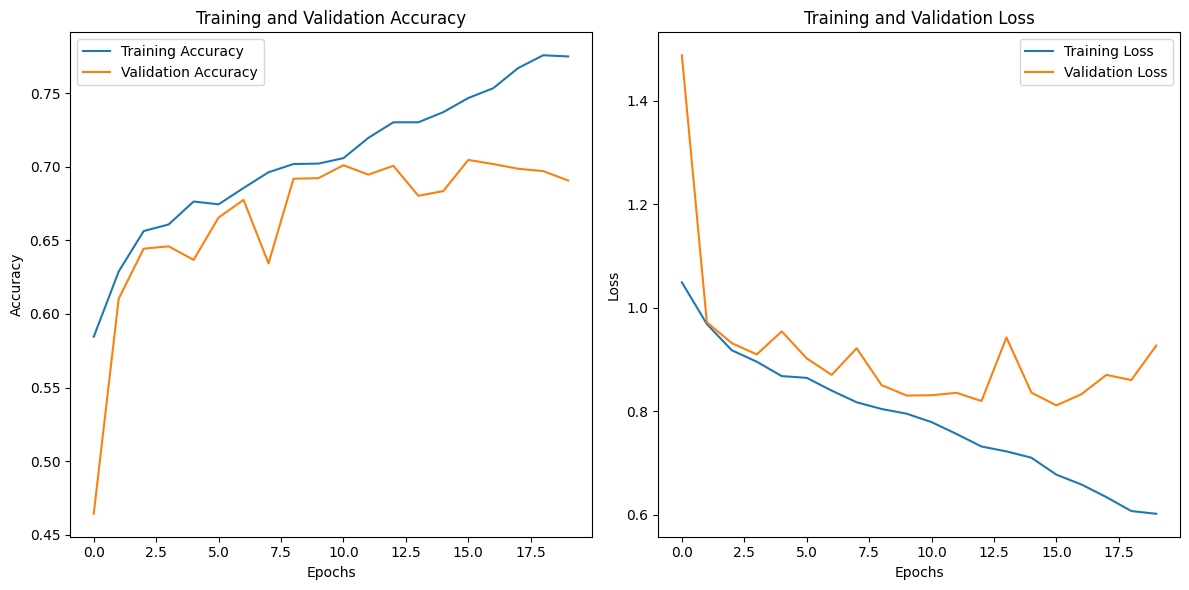

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()